In [7]:
library("ggplot2")
library("dplyr")
library("tidyr")
install.packages(c("MMWRweek", "lubridate"))
library(MMWRweek)
library(quantreg)

library("lubridate")


The downloaded binary packages are in
	/var/folders/3d/mrj5ym354zl424bqr1073p1w0000gq/T//Rtmp2qSbq2/downloaded_packages


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [8]:
######################
# Statewide analysis #
######################
# Covid deaths are overcounted by about 80k in 2021. Not as much as expected, but this means that we can't use 
# non-covid death counts as a response to vaccine deaths, i.e. we would get negative deaths predicted.
# A few other things things to note
# 1. Each state has a different deviation from pre-2020 non-flu deaths -> different diagnoses statewide
# 2. There is a discrete jump up in covid deaths Jan 2020, and a corresponding jump down in non-flu deaths

# Also, we show
# 1. Raw statewide death counts as a fraction of total
# 2. Normalized statewide death counts
# 3. Relative contribution from each state
# California	0.12407822
# `New York City`	0.11347172
# Florida	0.06615664
# Texas	0.06427249
us_death = read.csv(file="../data//Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv")
us_death$Week.Ending.Date = mdy(us_death$Week.Ending.Date)
us_death = us_death[year(us_death$Week.Ending.Date) < 2023, ]
us_death = us_death[!is.na(us_death$Total.Deaths) & !is.na(us_death$Week.Ending.Date), ]

# Read data from 2014-2019
us_death_old = read.csv("../data/Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2019.csv")
us_death_old$Week.Ending.Date = mdy(us_death_old$Week.Ending.Date)
us_death_old = us_death_old[!is.na(us_death_old$All..Cause) & !is.na(us_death_old$Week.Ending.Date), ]
us_death_old$Total.Deaths = us_death_old$All..Cause
us_death_old$data_set = "2014-2019"
us_death$data_set = "2020-2021"
us_death_old$State = us_death_old$Jurisdiction.of.Occurrence
us_death_old$flu_like_deaths = us_death_old$Influenza.and.pneumonia..J10.J18.

us_death$flu_like_deaths = us_death$Pneumonia..Influenza..or.COVID.19.Deaths
colnames(us_death)
colnames(us_death_old)
us_death_all = rbind(us_death_old[,c("Week.Ending.Date", "Total.Deaths", "flu_like_deaths", "data_set", "MMWR.Week", "State")], 
                                  us_death[,c("Week.Ending.Date", "Total.Deaths", "flu_like_deaths", "data_set", "MMWR.Week", "State")])
us_death_all$days = us_death_all$Week.Ending.Date - us_death_all$Week.Ending.Date[1]

[1] "Data.as.of"                              
 [2] "Start.Date"                              
 [3] "End.Date"                                
 [4] "Group"                                   
 [5] "Year"                                    
 [6] "Month"                                   
 [7] "MMWR.Week"                               
 [8] "Week.Ending.Date"                        
 [9] "State"                                   
[10] "COVID.19.Deaths"                         
[11] "Total.Deaths"                            
[12] "Percent.of.Expected.Deaths"              
[13] "Pneumonia.Deaths"                        
[14] "Pneumonia.and.COVID.19.Deaths"           
[15] "Influenza.Deaths"                        
[16] "Pneumonia..Influenza..or.COVID.19.Deaths"
[17] "Footnote"                                
[18] "data_set"                                
[19] "flu_like_deaths"

[1] "Jurisdiction.of.Occurrence"                                                                       
 [2] "MMWR.Year"                                                                                        
 [3] "MMWR.Week"                                                                                        
 [4] "Week.Ending.Date"                                                                                 
 [5] "All..Cause"                                                                                       
 [6] "Natural.Cause"                                                                                    
 [7] "Septicemia..A40.A41."                                                                             
 [8] "Malignant.neoplasms..C00.C97."                                                                    
 [9] "Diabetes.mellitus..E10.E14."                                                                      
[10] "Alzheimer.disease..G30."                                                                          
[11] "Influenza.and.pneumonia..J10.J18."                                                                
[12] "Chronic.lower.respiratory.diseases..J40.J47."                                                     
[13] "Other.diseases.of.respiratory.system..J00.J06.J30.J39.J67.J70.J98."                               
[14] "Nephritis..nephrotic.syndrome.and.nephrosis..N00.N07.N17.N19.N25.N27."                            
[15] "Symptoms..signs.and.abnormal.clinical.and.laboratory.findings..not.elsewhere.classified..R00.R99."
[16] "Diseases.of.heart..I00.I09.I11.I13.I20.I51."                                                      
[17] "Cerebrovascular.diseases..I60.I69."                                                               
[18] "flag_allcause"                                                                                    
[19] "flag_natcause"                                                                                    
[20] "flag_sept"                                                                                        
[21] "flag_neopl"                                                                                       
[22] "flag_diab"                                                                                        
[23] "flag_alz"                                                                                         
[24] "flag_inflpn"                                                                                      
[25] "flag_clrd"                                                                                        
[26] "flag_otherresp"                                                                                   
[27] "flag_nephr"                                                                                       
[28] "flag_otherunk"                                                                                    
[29] "flag_hd"                                                                                          
[30] "flag_stroke"                                                                                      
[31] "Total.Deaths"                                                                                     
[32] "data_set"                                                                                         
[33] "State"                                                                                            
[34] "flu_like_deaths"

In [9]:
detrend = function(times, values, dates) {
    idx = year(dates) < 2020
    rq.fit = rq(values[idx] ~ times[idx])
    detrended = as.numeric(values - times * rq.fit$coef[2])
    detrended
}

In [10]:
state_centered = us_death_all %>% group_by(State) %>% summarize(
    flu_like_deaths=flu_like_deaths,
    detrended = detrend(days, Total.Deaths, Week.Ending.Date),
    detrended_flu_like = detrend(days, flu_like_deaths, Week.Ending.Date),
    Week.Ending.Date = Week.Ending.Date,
    Total.Deaths = Total.Deaths,
    data_set = data_set,
    MMWR.Week = MMWR.Week,
    State = State)
head(state_centered)

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was
deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that
  `reframe()` always returns an ungrouped data frame and adjust
  accordingly.”
`summarise()` has grouped output by 'State'. You can override using the
`.groups` argument.


State,flu_like_deaths,detrended,detrended_flu_like,Week.Ending.Date,Total.Deaths,data_set,MMWR.Week
<chr>,<int>,<dbl>,<dbl>,<date>,<int>,<chr>,<int>
Alabama,38,1057.0000,38,2014-01-04,1057,2014-2019,1
Alabama,37,1076.7215,37,2014-01-11,1077,2014-2019,2
Alabama,34,1047.4430,34,2014-01-18,1048,2014-2019,3
Alabama,42,1021.1646,42,2014-01-25,1022,2014-2019,4
Alabama,26,1039.8861,26,2014-02-01,1041,2014-2019,5
Alabama,31,990.6076,31,2014-02-08,992,2014-2019,6


In [11]:
find_median = function(weeks, values, dates) {
    idx = year(dates) < 2022
    state_deaths = data.frame(weeks=weeks, values=values, dates=dates)
    median = state_deaths[idx,] %>% group_by(weeks) %>% summarise(med = median(values, na.rm=TRUE))
    merged = merge(state_deaths, median, by="weeks")
    merged$med[order(merged$dates)]
}
find_sd = function(weeks, values, dates) {
    idx = year(dates) < 2022
    state_deaths = data.frame(weeks=weeks, values=values, dates=dates)
    std = state_deaths[idx,] %>% group_by(weeks) %>% summarise(std = sd(values, na.rm=TRUE) / sqrt(length(values)))
    merged = merge(state_deaths, std, by="weeks")
    merged$std[order(merged$dates)]
}

In [12]:
state_centered = state_centered %>% group_by(State) %>% summarize(
    flu_like_deaths=flu_like_deaths,
    detrended = detrended,
    detrended_flu_like = detrended_flu_like,
    median = find_median(MMWR.Week, detrended, Week.Ending.Date),
    std = find_sd(MMWR.Week, detrended, Week.Ending.Date),
    median_flu_like = find_median(MMWR.Week, detrended_flu_like, Week.Ending.Date),
    Week.Ending.Date = Week.Ending.Date,
    Total.Deaths = Total.Deaths,
    data_set = data_set,
    MMWR.Week = MMWR.Week)
state_centered$centered = state_centered$detrended - state_centered$median
state_centered$centered_high = state_centered$detrended - (state_centered$median - 2*state_centered$std)
state_centered$centered_low = state_centered$detrended - (state_centered$median + 2*state_centered$std)
state_centered$centered_flu_like = state_centered$detrended_flu_like - state_centered$median_flu_like
state_centered$non_flu_deaths = state_centered$Total.Deaths - state_centered$flu_like_deaths
state_centered$detrended_non_flu_like = state_centered$detrended - state_centered$detrended_flu_like
state_centered$centered_non_flu_like = state_centered$centered - state_centered$centered_flu_like
state_centered$centered_non_flu_like_high = state_centered$centered_high - state_centered$centered_flu_like
state_centered$centered_non_flu_like_low = state_centered$centered_low - state_centered$centered_flu_like

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was
deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that
  `reframe()` always returns an ungrouped data frame and adjust
  accordingly.”
`summarise()` has grouped output by 'State'. You can override using the
`.groups` argument.


In [13]:
write.csv(state_centered, "../data/state_centered_2023.csv")

In [14]:
sum_deaths = (state_centered %>% group_by(State) %>% summarize(sum=sum(Total.Deaths)))
sum_deaths = sum_deaths[order(sum_deaths$sum), ]
largest_ten = tail(sum_deaths, 10)$State
sm_ten = tail(sum_deaths, 10)$State

In [11]:
sum_deaths$State

[1] "Alaska"               "Wyoming"              "Vermont"             
 [4] "District of Columbia" "North Dakota"         "South Dakota"        
 [7] "Delaware"             "Montana"              "Rhode Island"        
[10] "Hawaii"               "New Hampshire"        "Idaho"               
[13] "Maine"                "Nebraska"             "New Mexico"          
[16] "Utah"                 "West Virginia"        "Nevada"              
[19] "Kansas"               "Puerto Rico"          "Iowa"                
[22] "Connecticut"          "Arkansas"             "Mississippi"         
[25] "Oregon"               "Colorado"             "Oklahoma"            
[28] "Minnesota"            "Louisiana"            "Kentucky"            
[31] "South Carolina"       "Maryland"             "Wisconsin"           
[34] "Alabama"              "Washington"           "New York City"       
[37] "Massachusetts"        "Arizona"              "Missouri"            
[40] "Indiana"              "Virginia"             "New Jersey"          
[43] "Tennessee"            "Georgia"              "North Carolina"      
[46] "Michigan"             "New York"             "Illinois"            
[49] "Ohio"                 "Pennsylvania"         "Florida"             
[52] "Texas"                "California"           "United States"

In [12]:
lower_ten = c("Texas", "Florida", "California", "Georgia", "Alabama", "Mississippi", "Louisiana", "New Mexico", "Arizona")



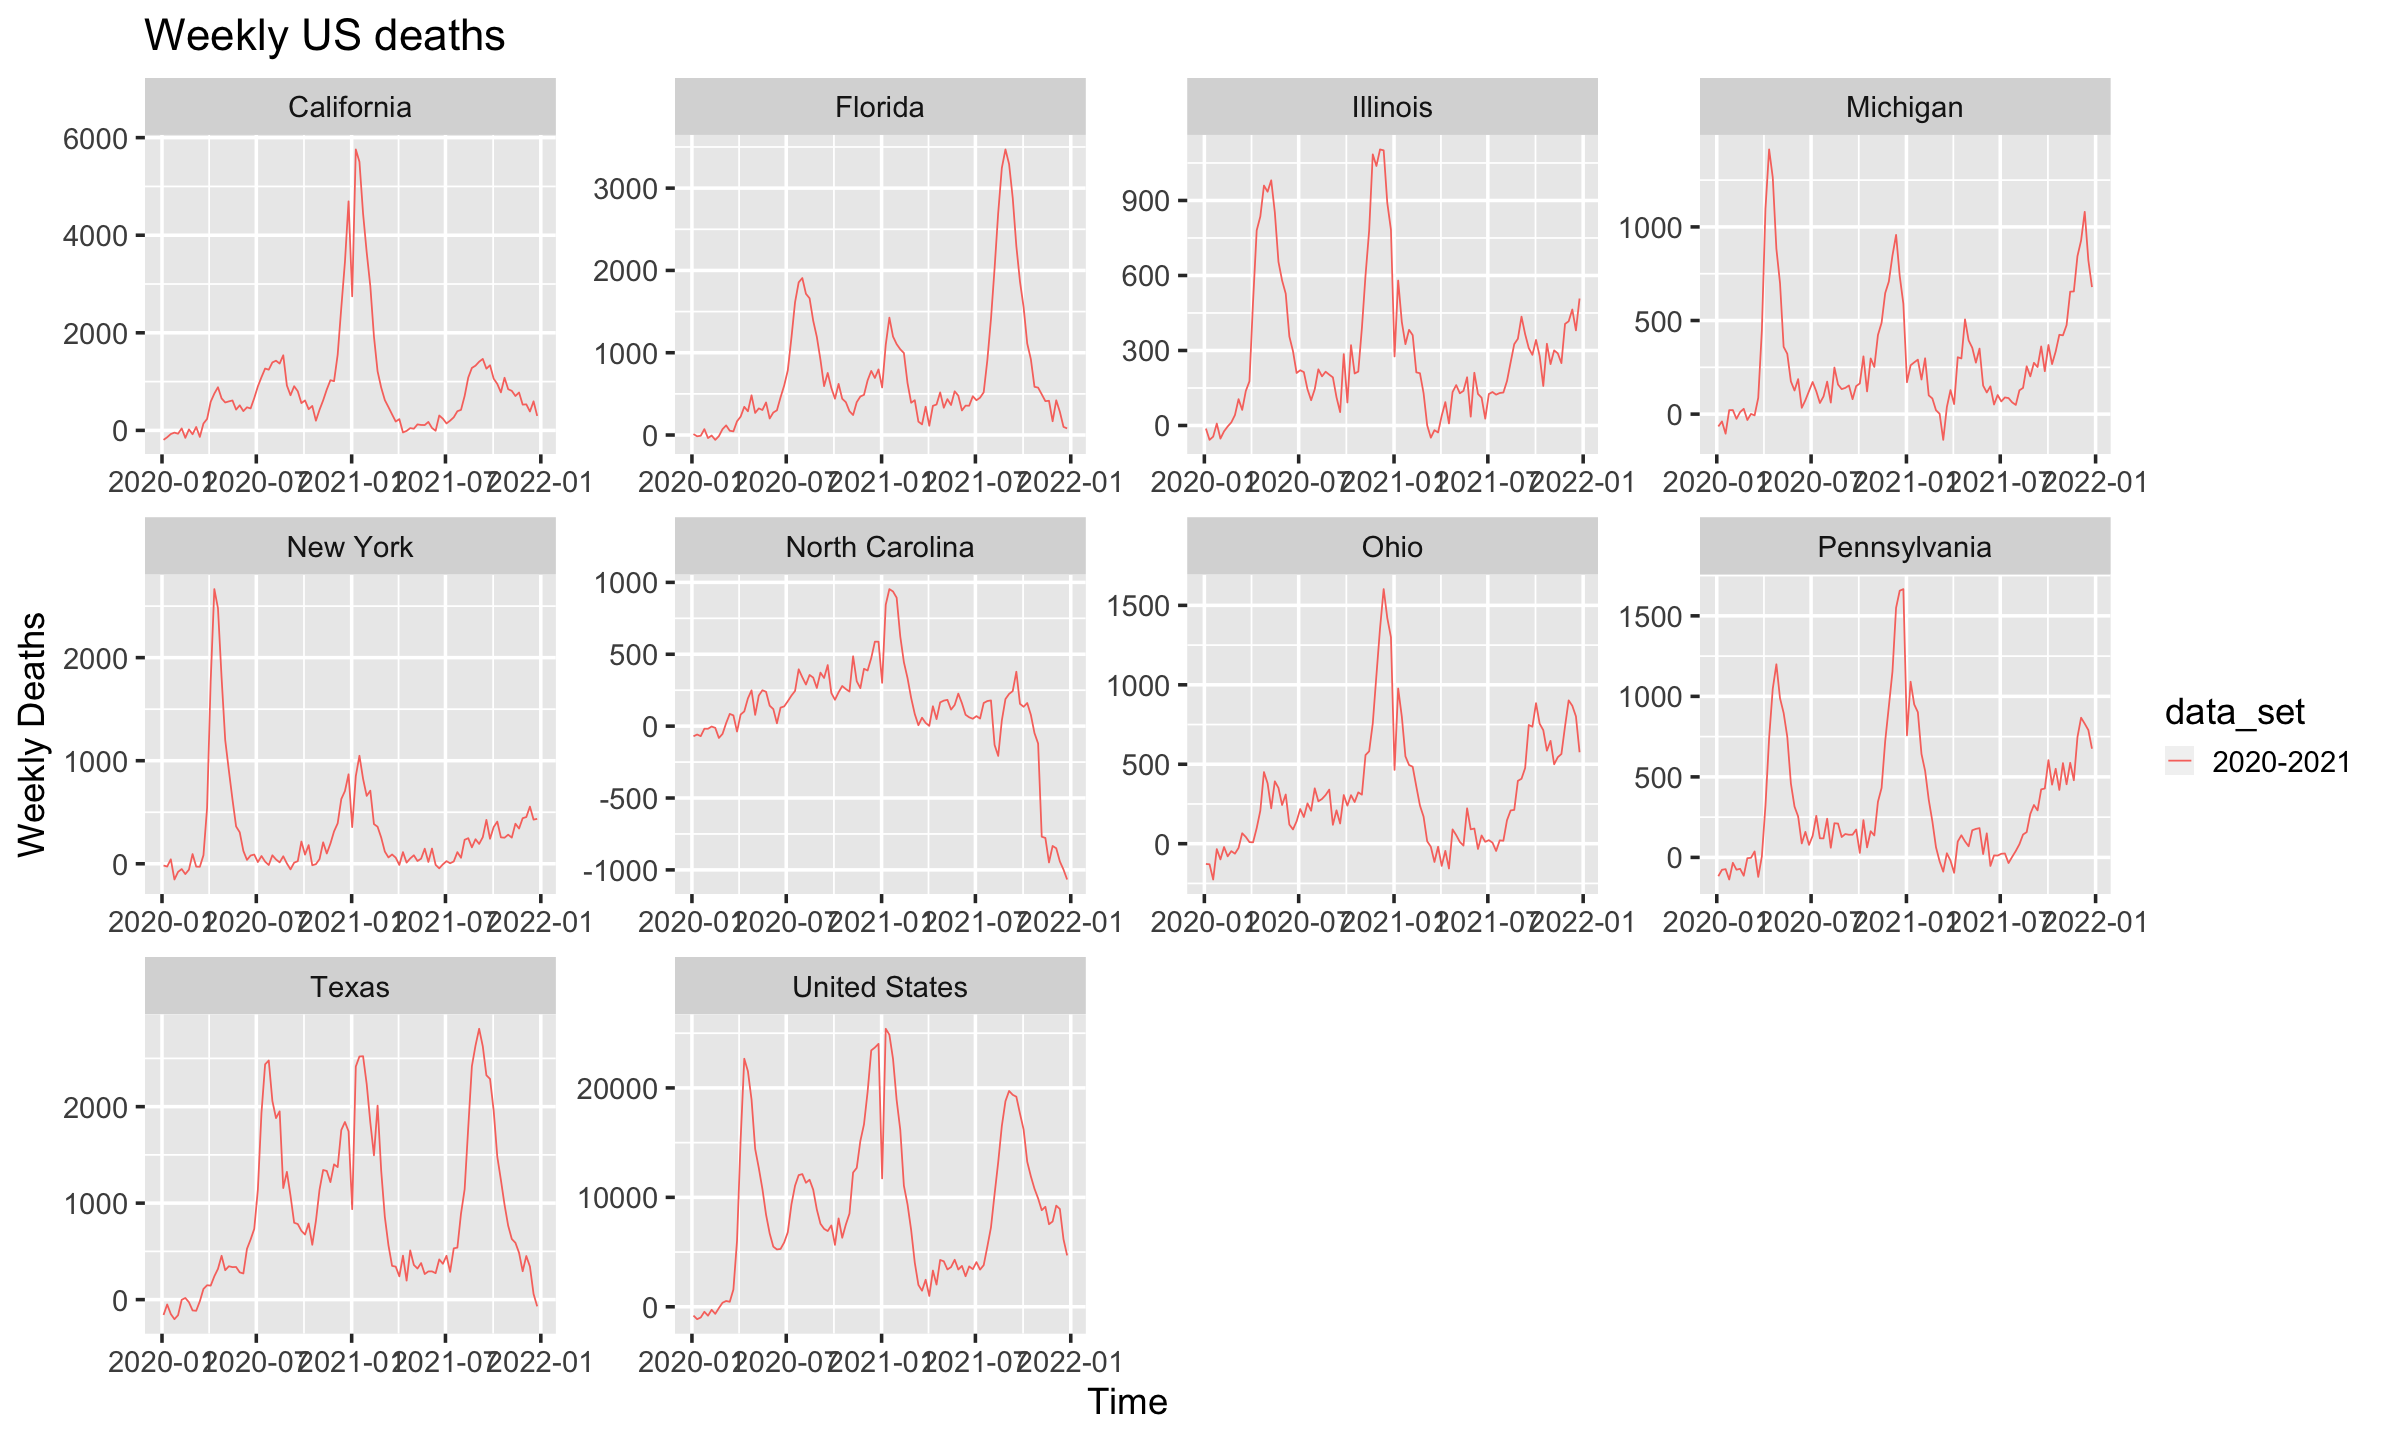

In [13]:
# Plot with quantile trend from 2014-2019
options(repr.plot.width=20, repr.plot.height=12)
b = ggplot(state_centered[state_centered$State %in% largest_ten & year(state_centered$Week.Ending.Date) > 2019,], 
           aes(x=Week.Ending.Date, y=detrended - median, color=data_set))
b + geom_line() + facet_wrap(~State, scales="free") +
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")

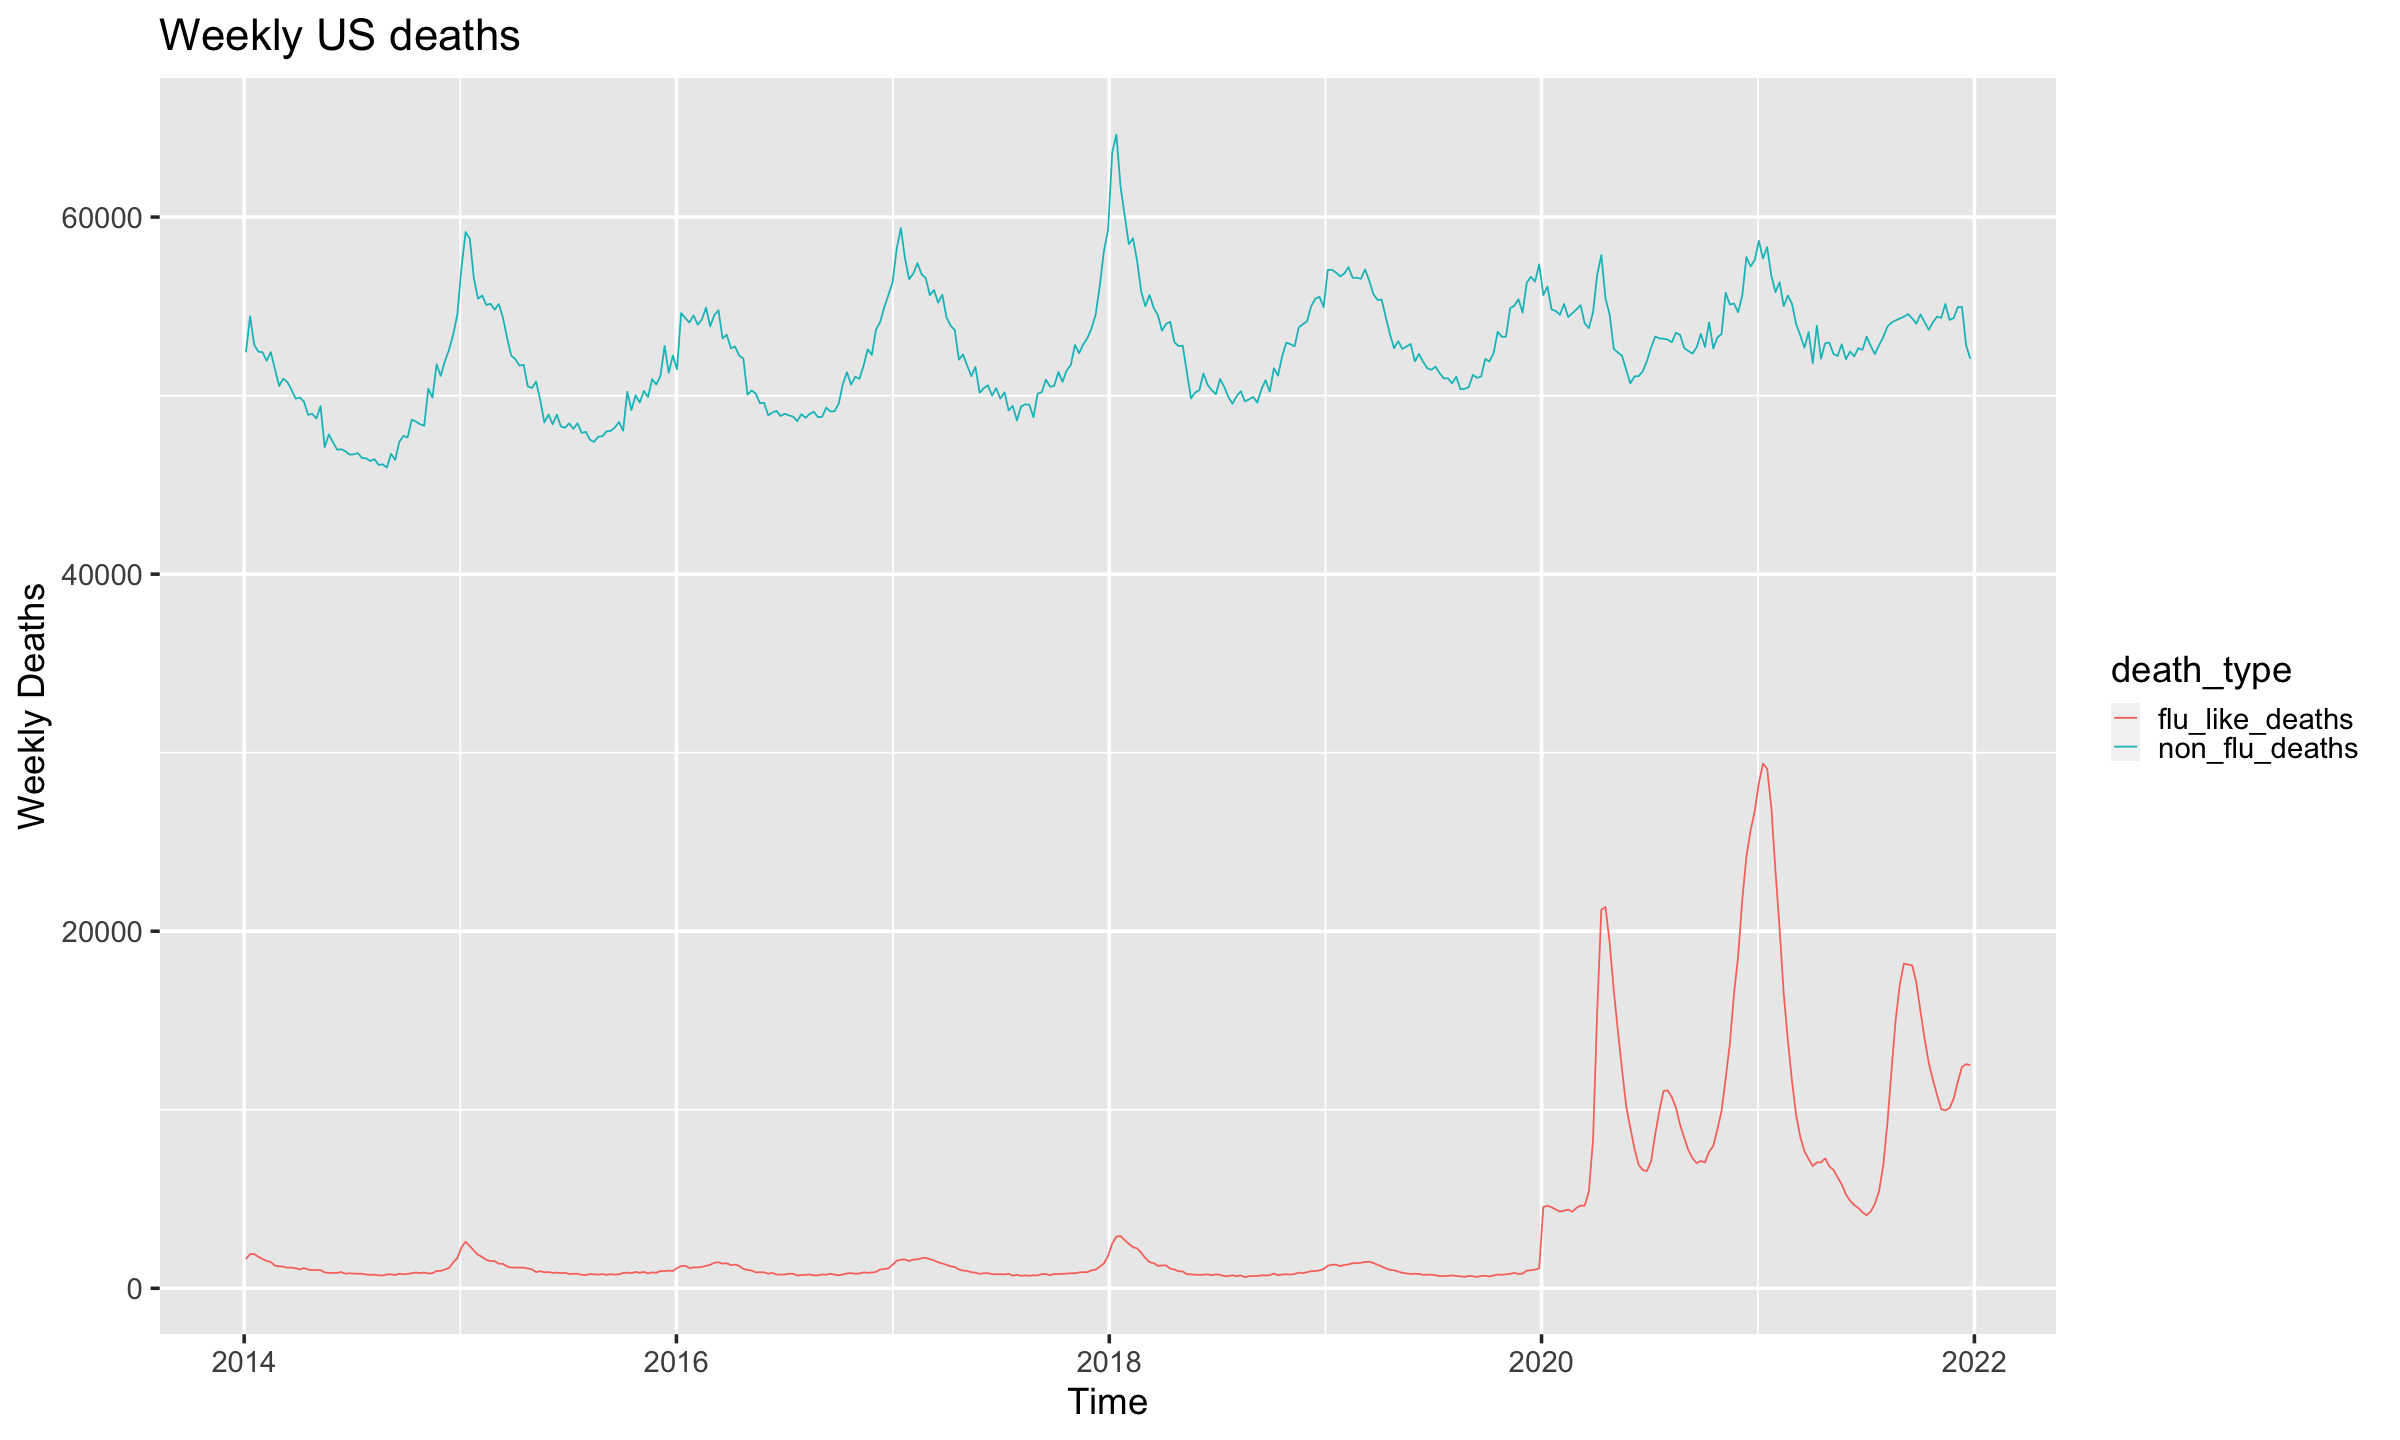

In [14]:
# Plot with quantile trend from 2014-2019
pivoted = pivot_longer(state_centered, cols = c("non_flu_deaths", "flu_like_deaths"), values_to="deaths", names_to="death_type")
options(repr.plot.width=20, repr.plot.height=12)
b = ggplot(pivoted[pivoted$State == "United States",], 
           aes(x=Week.Ending.Date, y=deaths, color=death_type))
b + geom_line() +
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")

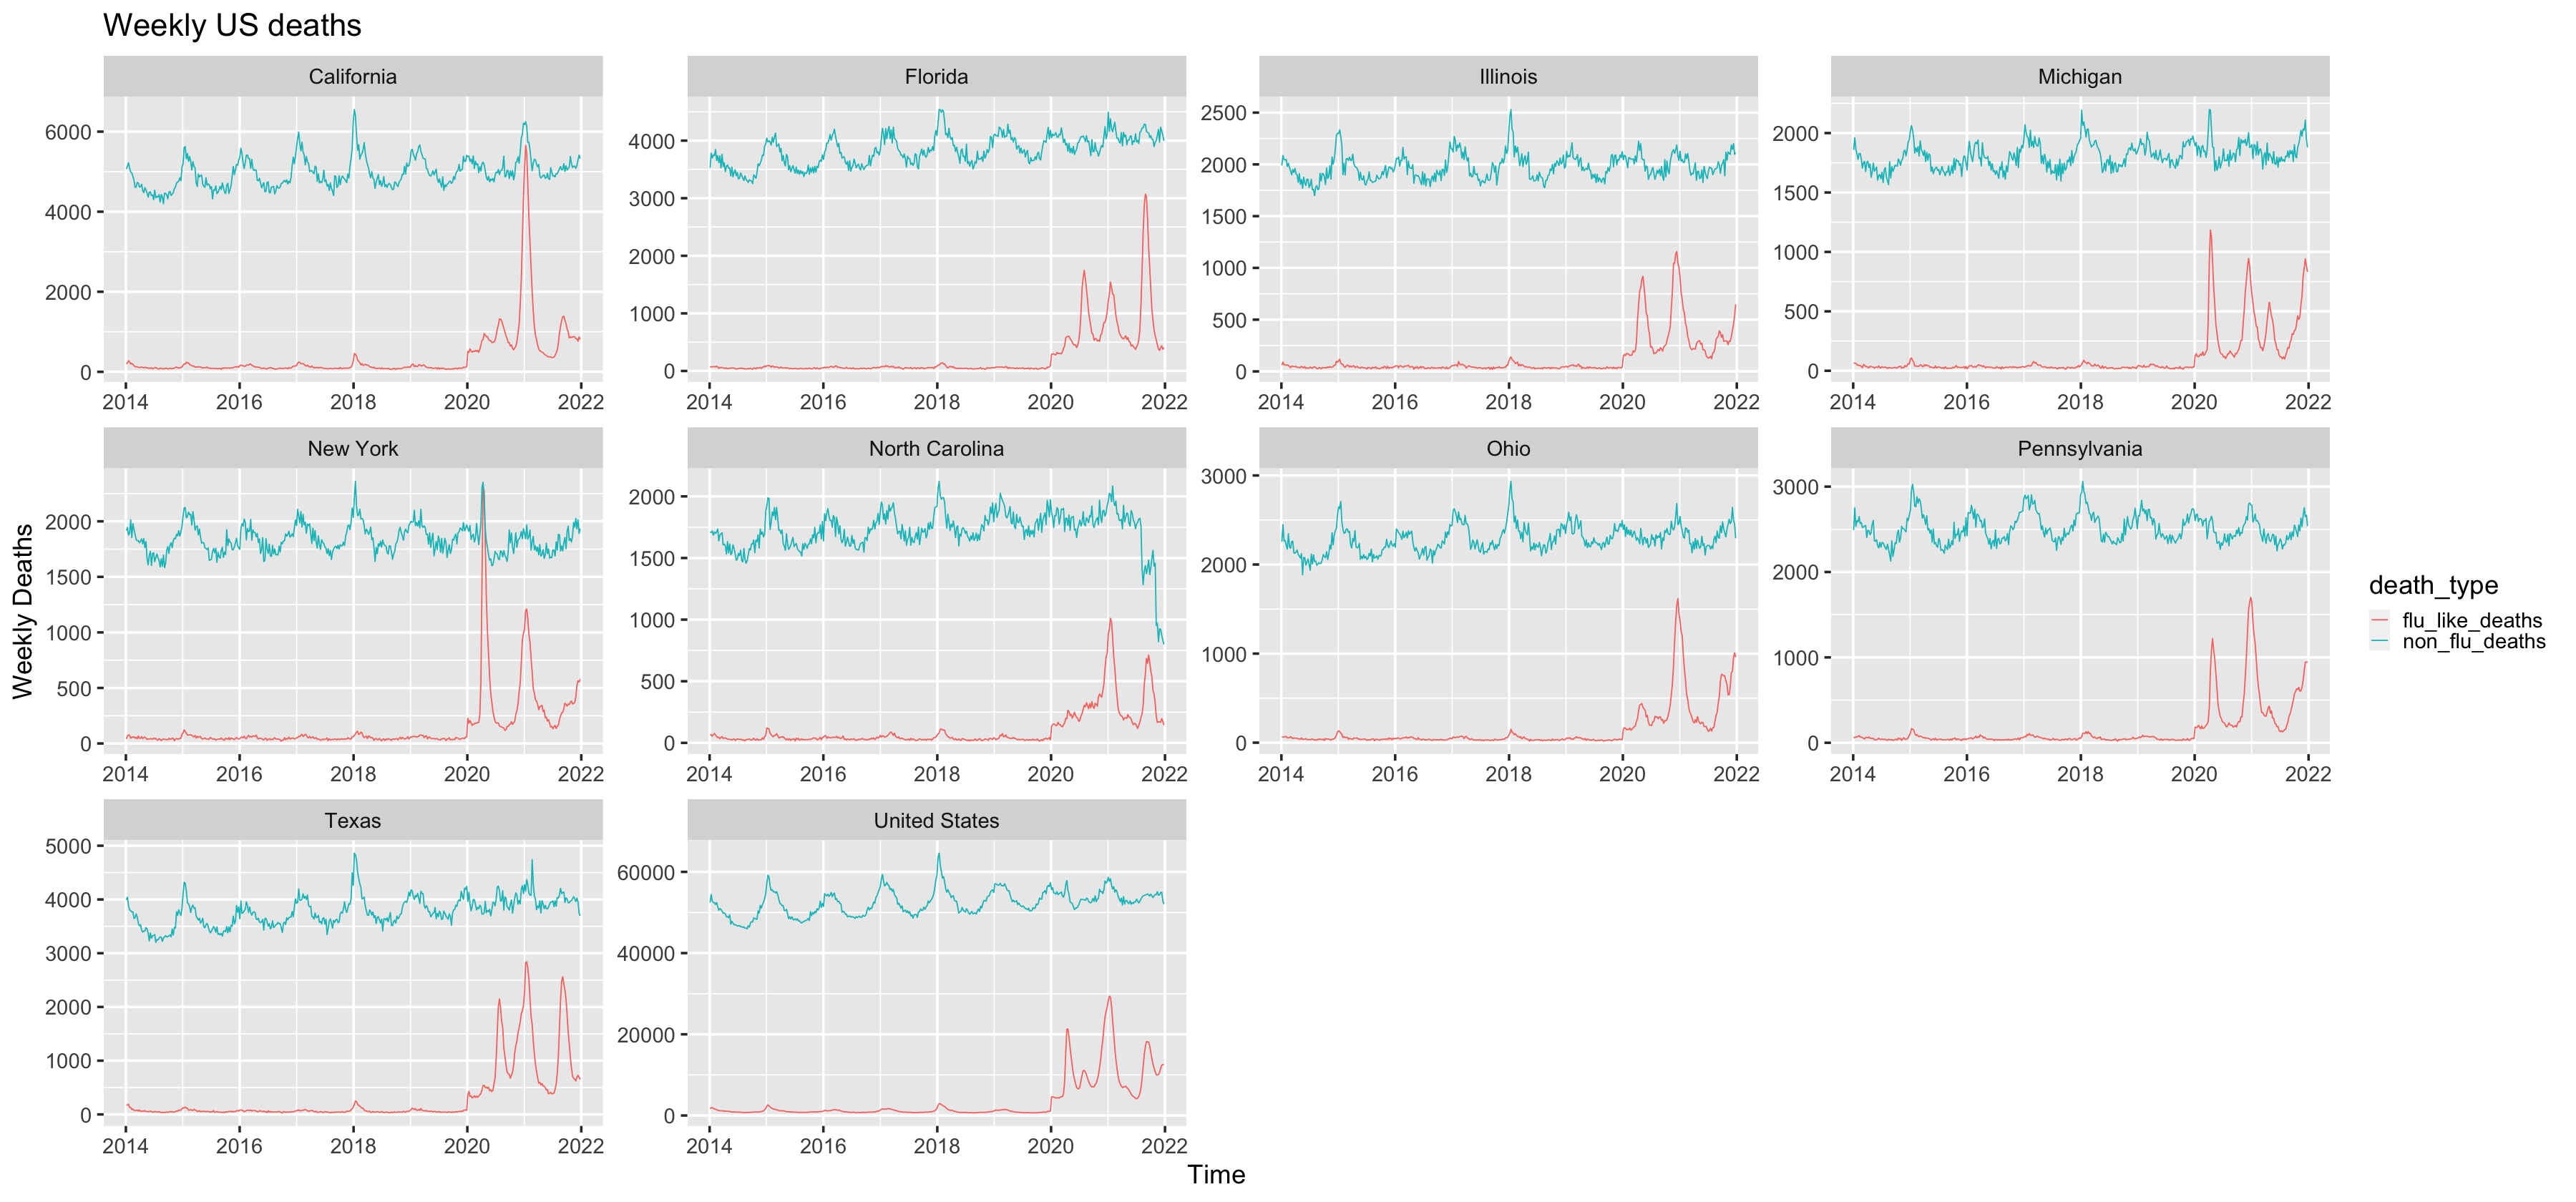

In [15]:
# Plot flu vs non-flu deaths statewide
pivoted = pivot_longer(state_centered, cols = c("non_flu_deaths", "flu_like_deaths"), values_to="deaths", names_to="death_type")
options(repr.plot.width=30, repr.plot.height=14)
b = ggplot(pivoted[pivoted$State %in% largest_ten,], 
           aes(x=Week.Ending.Date, y=deaths, color=death_type))
b + geom_line() + facet_wrap(~State, scales="free") +
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")

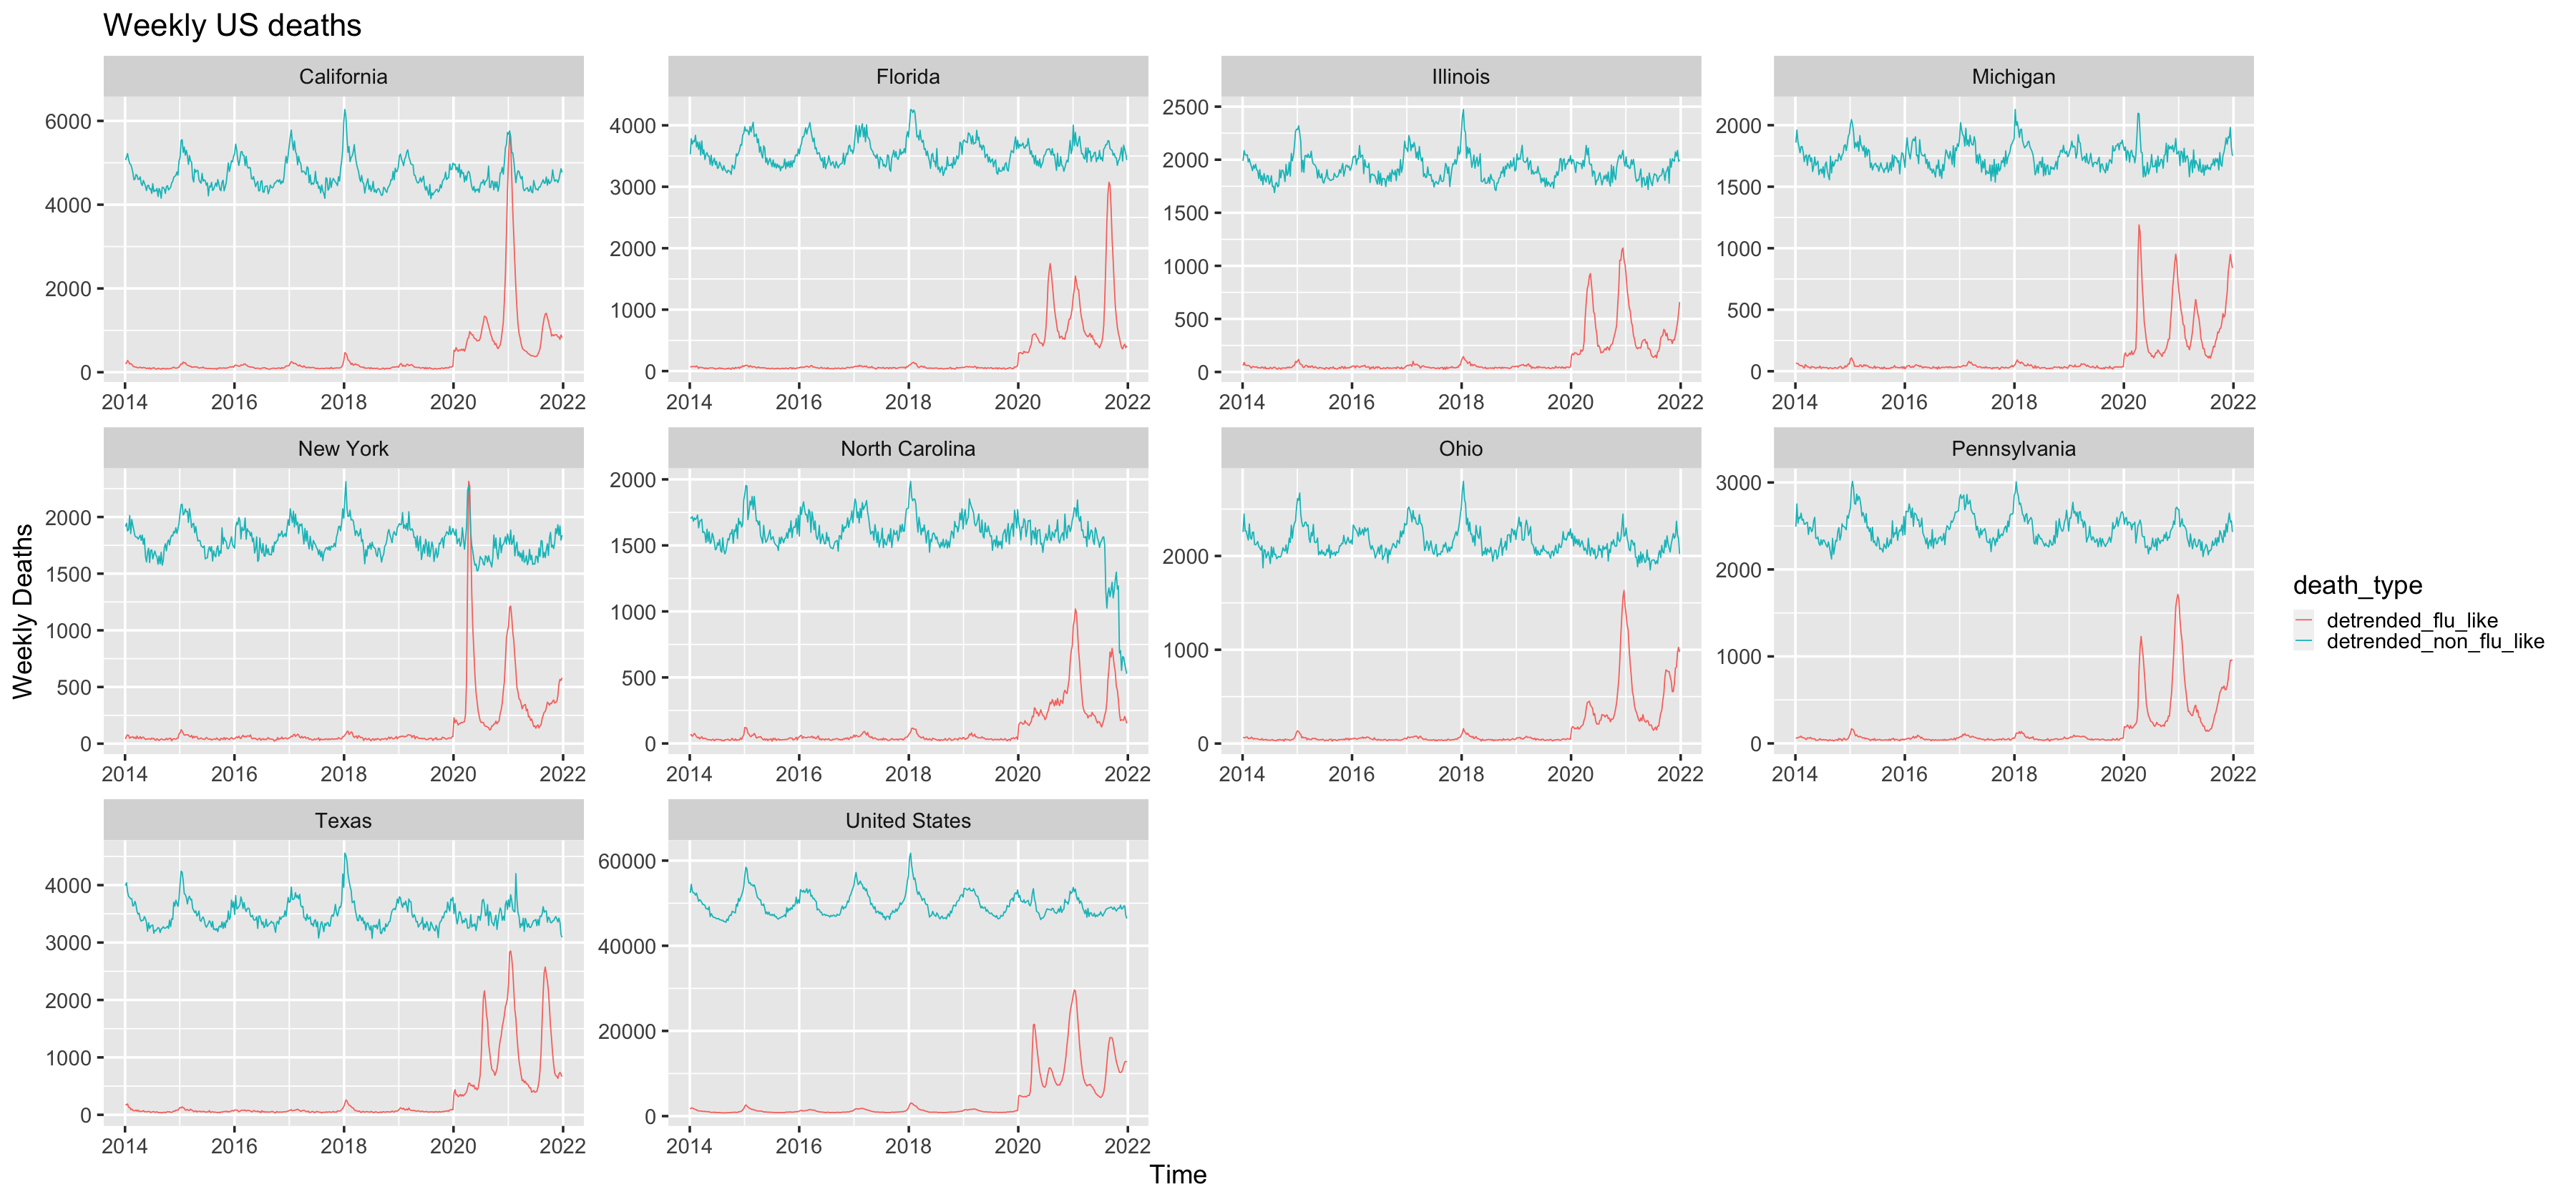

In [16]:
# Plot detrended flu vs non-flu deaths statewide
pivoted = pivot_longer(state_centered, cols = c("detrended_non_flu_like", "detrended_flu_like"), values_to="deaths", names_to="death_type")
options(repr.plot.width=30, repr.plot.height=14)
b = ggplot(pivoted[pivoted$State %in% largest_ten,], 
           aes(x=Week.Ending.Date, y=deaths, color=death_type))
b + geom_line() + facet_wrap(~State, scales="free") +
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")

In [17]:
# A few things to note
# 1. Each state has a different deviation from pre-2020 non-flu deaths -> different diagnoses statewide
# 2. There is a discrete jump up in covid deaths Jan 2020, and a corresponding jump down in non-flu deaths

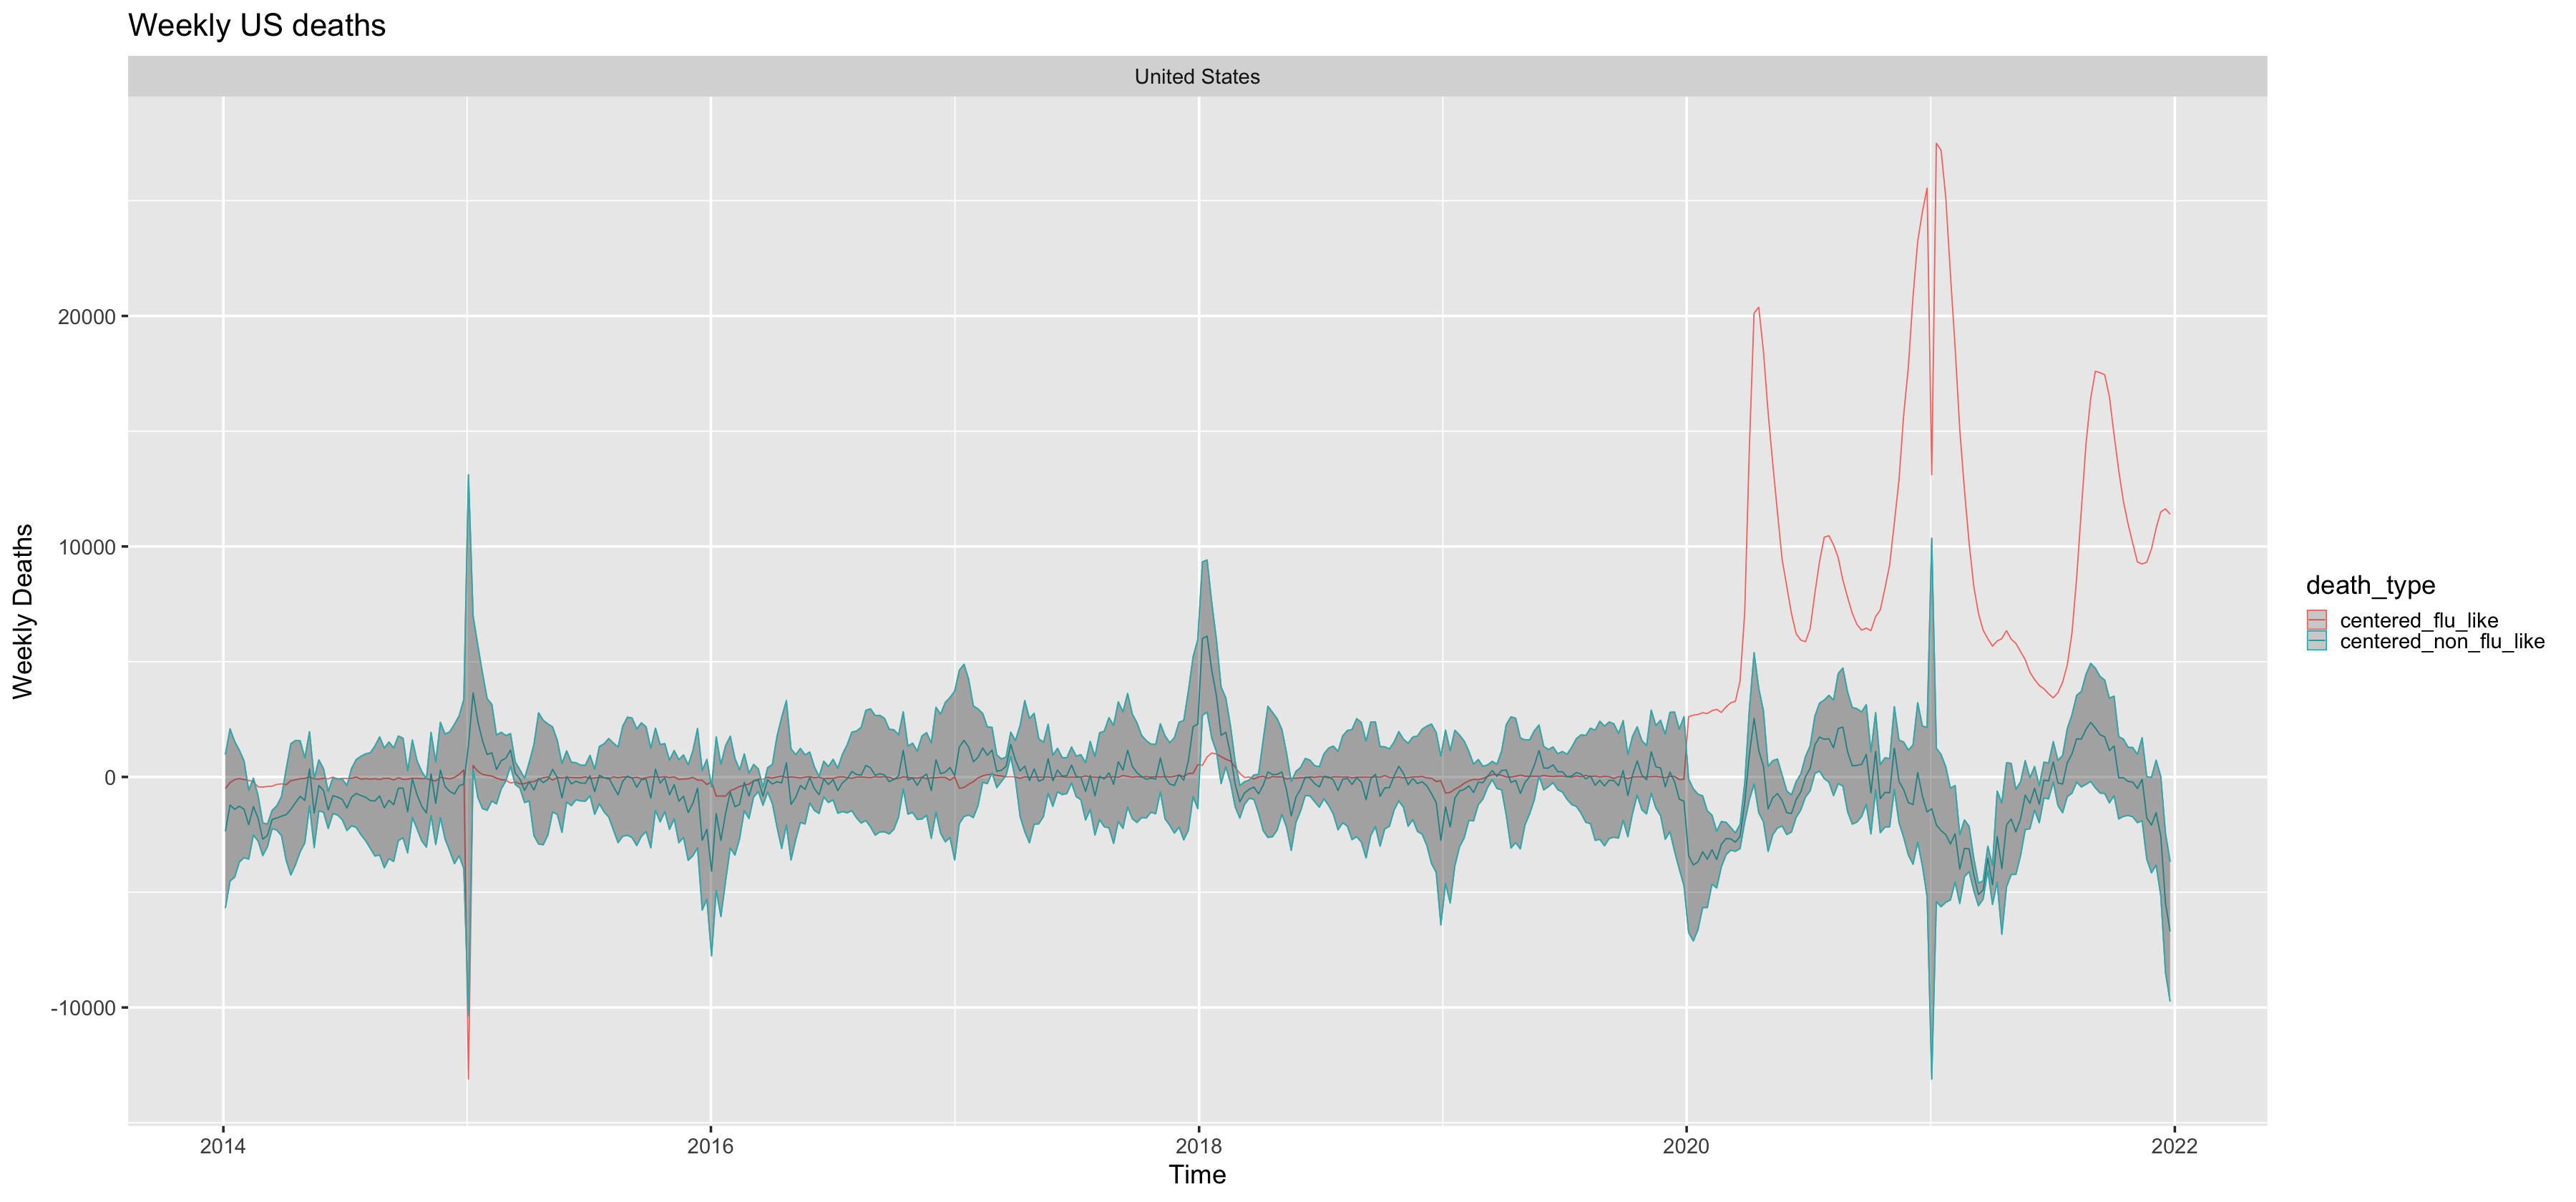

In [23]:
# Plot centered flu vs non-flu deaths statewide
pivoted = pivot_longer(state_centered, cols = c("centered_non_flu_like", "centered_flu_like"), values_to="deaths", names_to="death_type")
options(repr.plot.width=30, repr.plot.height=14)
b = ggplot(pivoted[pivoted$State %in% c("United States"),], 
           aes(x=Week.Ending.Date, y=deaths, color=death_type)) + 
    geom_line() + facet_wrap(~State, scales="free") +
 theme_gray(base_size = 22) + 
 geom_ribbon(aes(ymin=centered_non_flu_like_low, ymax=centered_non_flu_like_high), alpha = 0.2) +
 labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")
ggsave("../figures/non-flu-vs-flu-us-mortality.png", width=14, height=5)
b

In [31]:
idx = year(state_centered$Week.Ending.Date) > 2019 & state_centered$State == "United States"
undercounted = sum(state_centered[idx,]$centered_non_flu_like)
undercounted_high = sum(state_centered[idx,]$centered_non_flu_like_high)
undercounted_low = sum(state_centered[idx,]$centered_non_flu_like_low)
sprintf("There are %d non-flu deaths less than in previous years.", (round(undercounted / 2)))
sprintf("Confidence Interval: [%d, %d]", (round(undercounted_low / 2)), (round(undercounted_high / 2)))

[1] "There are -50645 non-flu deaths less than in previous years."

[1] "Confidence Interval: [-150144, 48853]"

In [30]:
undercounted_low
abs(round(undercounted_high / 2))

[1] -300287

[1] 48853

In [35]:
unique(year(state_centered$Week.Ending.Date))

[1] 2014 2015 2016 2017 2018 2019 2020 2021

In [ ]:
# 1. Find # signs pos vs. neg (p, n)  S(>2020) = p / (p + n)   , 365
# 2. Permutation test: shuffle all data and recompute S*(all years), B times
# 3. Find # {S > P(null)} / B  , significant at alpha level



In [45]:
n = 365
sample(seq(1, n), 365, replace=TRUE)

[1] 182 163 155 207 256 155 365 357 270 120  22 277 200  50 125 141  98 112
 [19] 155  97 279  52 290  62  88 170 310  12 140 347 183 248 212 155  60  94
 [37] 215  35 188 171 314 178 151 323  88 170 358   9   6 198 274 359 128  62
 [55]  74 322 287 210  98 321 363 335  97  34 178 239 333 151 356  99 270 236
 [73] 203 272 255 331 350  82 275  17  76  58 144  25 288  50 147  72 228 112
 [91] 193 362 240 251 195 323  28  71 191 345 230  41 146  69  92 207 112 335
[109]  15 135 341  80 275 174 158  94 220 345 150 363  20  98 109 350 255 129
[127] 349 170   7 130 358 206   7 254 279 193 251  54 151  84 346 262 221 159
[145]  63 330  63 328 329 150 152 269 195 113 186  35  54 227 192 272 152 282
[163] 156  76 216 168 239  40 105  46 307 341 344 342  14 161  65  45 362 363
[181] 155 156  58 127 154 344 211  31 132 102 333  32 259 181 270 250 104  76
[199] 297  69  98 289 253 268 283 181 230  54 113 279 150 200 325  83 161 340
[217] 356 296 258 169 118 137  28 292 318   7   9  74 120 162  57 194  94 152
[235] 192  41 341 111 124 168 203 232  47 331 115   3 231 145 249 289 229 104
[253] 232 220  30 291 353 204 115 346 248  72 141 278 176 211  38  85  76  75
[271] 117 362 223 184  32  48 131 333 313 247 117  39 299 192 156 286 116 102
[289] 330 238 158 154 290 302 321   2  39  41 184 322 108  70 242  52 245  94
[307]  56 236  64 240 109 200 268 235 126  87 192  76 244 149 267 128 267   3
[325] 128  31 338 111 194 205 266 257  30 270  34  83 323 124 174 217  77  70
[343] 198 215 338 178 354 251 202  14 209 320 228 108 251 280 205 283  47 175
[361] 115  69   4  60 332

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


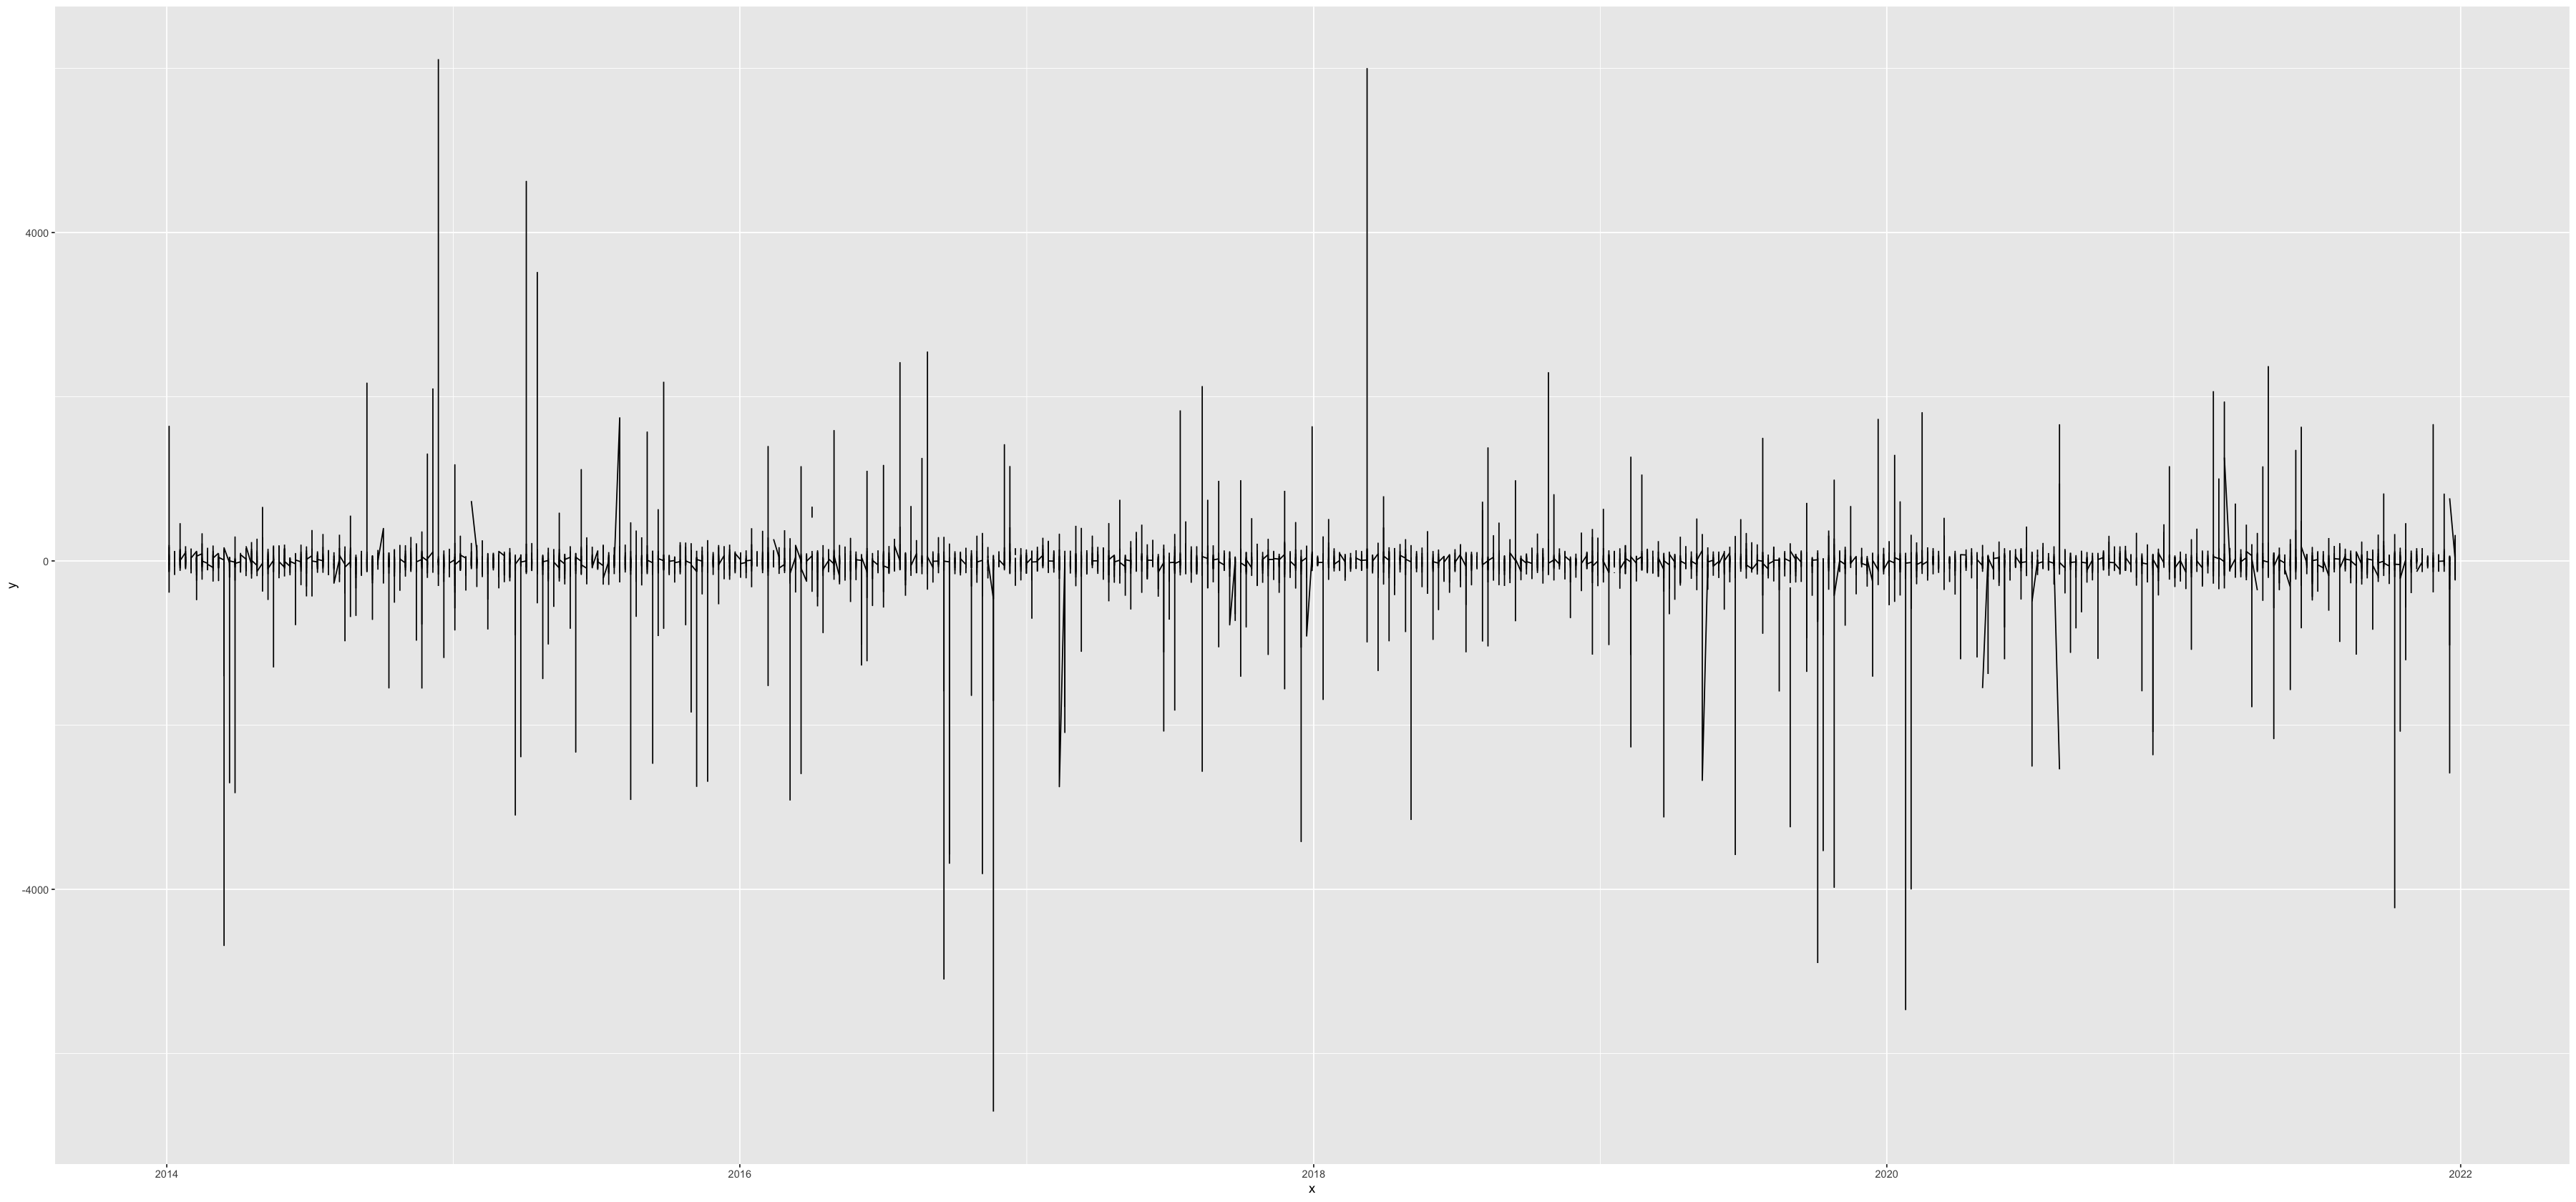

In [51]:
df = data.frame(y=sample(state_centered$centered_non_flu_like, length(state_centered$centered_non_flu_like)),
          x=state_centered$Week.Ending.Date)
ggplot(df, aes(x,y)) + geom_line()

In [ ]:
df$x[year()]

In [52]:


# state_centered[year(state_centered$Week.Ending.Date) > 2019 & year(state_centered$Week.Ending.Date) <= 2020,]$centered_non_flu_like >